<a href="https://colab.research.google.com/github/d823944/ML100-Days/blob/master/Home/Day088_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [2]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y 

train, test = keras.datasets.cifar10.load_data()

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

170500096/170498071 [==============================] - 24s 0us/step


In [0]:
#from keras.layers import BatchNormalization


# import BatchNormalization
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation, Dropout


def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """
    TO DO:
    Build your own model
    """
    # instantiate model
    model = Sequential()

    # we can think of this chunk as the input layer
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            model.add(Dense(num_neurons[i], input_shape=input_shape))
        else:
            model.add(Dense(num_neurons[i]))
                      
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
                      
    model.add(Dense(output_units))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_fp_tp(Callback):
    """Define a callback function to collect tp/tn, named Record_fp_tp.
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
                
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        from sklearn.metrics import recall_score
        # True positive rate, Recall, Sensitivity 
        logs['val_tp'] = recall_score(y_true, y_pred, average='weighted')
        
rec_tptn = Record_fp_tp()

In [57]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""
To do:
Fit the model with rec_tptn callback_fn
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""
To do:
Collect tp/tn from model history
"""
valid_tp = model.history.history["val_tp"]
valid_tn = [acc * 2 - tp for (acc, tp) in zip(valid_acc, valid_tp)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_78 (Batc (None, 256)               1024      
_________________________________________________________________
activation_78 (Activation)   (None, 256)               0         
__________

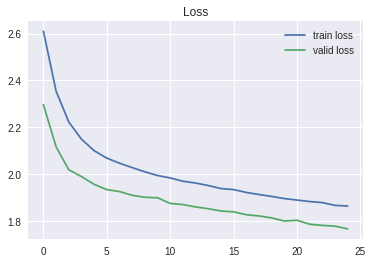

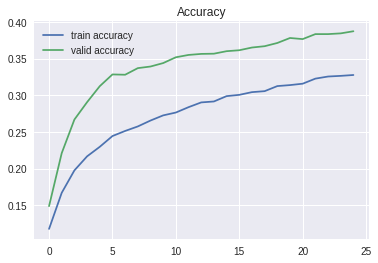

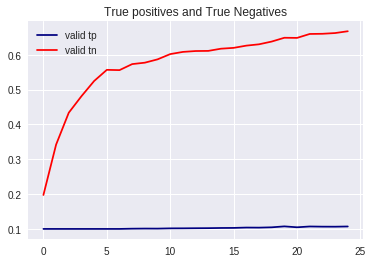

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()